## Natural Language Processing
* Name: Soumyajoy Kundu
* Roll Number: MDS202349

### Assignment 04 and 05

* Use this partial data set (sourced from Kaggle) which contains research articles related to COVID-19. (same used in Assignment 01)
* This corpus has around 56000+ files.
* All the instructions are followed that were mentioned in Assignment 01 - 03.
* Build a skipgram model to generate the word embedding.

**Note**:
All fine prints from the earlier assignments apply here with respect to submission guidelines.

### Importing Libraries

In [ ]:
import os  # For interacting with the operating system
import re  # For regular expressions
import time  # For measuring time
import json  # For handling JSON files
import zipfile  # For handling zip files
import string  # For string manipulation
import csv  # For handling CSV files
import pickle  # For serializing and deserializing Python objects
from collections import Counter  # For counting elements
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting
import math  # For mathematical functions
from multiprocessing import Pool, Manager  # For parallel processing

  * Used TPU v2-8
  * Number of cores = 96

In [ ]:
tpu_num_cores = os.cpu_count()
tpu_num_cores

96

In [ ]:
# Path to the zip file
zip_file_path = '/content/pdf_json.zip'

# Path where the file is extracted
extract_dir = '/content/pdf_json'

start = time.time()
# Creating the directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
end = time.time()

print(f"Files extracted to {extract_dir}")
print(f"Time taken to unzip: {end-start} seconds")

Files extracted to /content/pdf_json
Time taken to unzip: 37.71924877166748 seconds


In [ ]:
# List a few files to confirm extraction
json_files = [f for f in os.listdir('/content/pdf_json/pdf_json') if f.endswith('.json')]

print(f"Total JSON files extracted: {len(json_files)}")
print("First 10 files:", json_files[:10])

Total JSON files extracted: 56528
First 10 files: ['202383e9c79c6dac9c6de7622681a2b2fdd699b6.json', '49861eebbc323ac1fda5c90a3f25b755300b7413.json', '3ba5a8bec872feebb62f6a1f384690ba1cd63a8b.json', '1450545d1da21d84ec1c78140e28137d11053826.json', '5cc7d19d8c064e59978daa0699ca18d5b139b0db.json', '1f7f3e09db31be0bc73e921a1034ec9de0d52ebe.json', '1fa4e53e298871ed4d6c9ec3f471cc5d49d20acf.json', '564cc276d915ea2b85434de9ea2427c41ca76bdd.json', '5a2aa19ff63d93bcc65037b428235a1f6a337b19.json', '2c29ff48c88939e57b87ce996f8769b37b386122.json']


## Assignment 04

### **Task 1**: Use the COVID-19 corpus
* Extract all the abstracts from the COVID-19 text files and use them as the corpus.
* Ensure that you create
a vocabulary of around 10,000 words.


* Extract the text content from the JSON-encoded data set and create a
text corpus.
* You may use any JSON library to extract the text

In [ ]:
def json2text(filename):
    '''
    Converts a JSON file to text.
    '''
    # Construct the full file path
    filepath = os.path.join('/content/pdf_json/pdf_json', filename)  # Add the directory path

    with open(filepath, encoding='latin-1') as file: # Use filepath instead of filename
        if filename.endswith('.json'):
            paper_content = json.load(file)
    abstract = ""
    title = ""

    # get the paper_id
    paper_id = paper_content['paper_id']

    # get the title
    if 'title' in paper_content:
      title = paper_content['title']

    # get the abstract
    if 'abstract' in paper_content:
      for abs in paper_content['abstract']:
          abstract = abstract + abs['text']

    # case-folding (all converted to lower case)
    return abstract.lower()

In [ ]:
def save_text_to_file(text, filename, output_dir):
    """
    Saves the given text to a file in the specified output directory.
    """
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    # Define the path to save the text file
    text_filename = os.path.join(output_dir, f"{filename}.txt")

    # Write the text to the file
    with open(text_filename, 'w', encoding='utf-8') as file:
        file.write(text)

In [ ]:
def process_json_file(json_file, output_dir):
    """
    Processes a single JSON file: extracts text and saves it to a file.
    """
    text = json2text(json_file)

    # Extract the base filename (without extension) to use as the text file name
    base_filename = os.path.splitext(os.path.basename(json_file))[0]

    # Save the extracted text to a file
    save_text_to_file(text, base_filename, output_dir)

In [ ]:
def extract_texts(json_files, output_dir):
    """
    Extracts text content from a list of JSON files in parallel and saves each text
    into a separate file within the specified output directory.
    """
    cpu_count = os.cpu_count()
    pool = Pool(processes=cpu_count)

    # Using starmap to pass both json_file and output_dir to process_json_file
    pool.starmap(process_json_file, [(json_file, output_dir) for json_file in json_files])

    pool.close()
    pool.join()

In [ ]:
# Path to create a folder where the json to text files will be kept.
output_dir = '/content/abstracts'

start = time.time()
extract_texts(json_files, output_dir)
end = time.time()

print("All json files are converted to text files containing abstracts...")
print(f"Time taken to extract texts: {end-start} seconds")

All json files are converted to text files containing abstracts...
Time taken to extract texts: 1.6233949661254883 seconds


#### Text Preprocessing
* Develop your pre-processing steps and order of steps.
* Some examples: case-folding, removal of numbers, etc.

In [ ]:
# Importing Libraries for NLP Tasks
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

In [ ]:
# Downloading Packages
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 43.5 MB/s eta 0:00:00


In [ ]:
from spellchecker import SpellChecker

In [ ]:
import re
import os
from nltk.corpus import stopwords

def remove_stopwords(text, lang_stopwords):
    """
    Removes stopwords from the given text.
    :param text: The input text.
    :param lang_stopwords: Set of stopwords to be removed.
    :return: The text with stopwords removed.
    """
    words = text.split()
    return ' '.join([word for word in words if word not in lang_stopwords])

In [ ]:
def preprocess_file(filepath, output_dir):
    """
    Preprocesses the text content of a single file by performing case-folding, removing numbers, and punctuation.
    Saves the preprocessed text to a new file in the output directory.
    Includes additional preprocessing steps based on user specifications.
    """
    with open(filepath, 'r', encoding='utf-8') as file:
        text = file.read()

    # 1. Remove non-ascii characters
    text = text.encode('ascii', errors='ignore').decode()

    # 2. Remove [numbers] in this format
    text = re.sub(r'\[\d+\]', '', text)

    # 3. Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # 3. Remove numbers
    text = re.sub(r'\d+', '', text)

    # 4. Remove non-alphanumeric characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # 5. Case folding (convert to lowercase)
    text = text.lower()

    # 6. Remove single-letter words (e.g., 'a', 'b')
    text = re.sub(r'\b[a-z]\b', '', text)

    # 7. Remove stopwords (English, German, French)
    stop_words = set(stopwords.words('english')) | set(stopwords.words('german')) | set(stopwords.words('french'))
    text = remove_stopwords(text, stop_words)

    # 8. Remove any email id, URL, or number with more than 9 digits
    text = re.sub(r'\S+@\S+', '', text)  # Remove email addresses
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'\b\d{10,}\b', '', text)  # Remove numbers greater than 9 digits

    # 9. Convert "$" to "dollars"
    text = text.replace('$', 'dollars')

    # 10. Remove words longer than 20 characters
    text = ' '.join([word for word in text.split() if len(word) <= 20])

    # 11. Spell check and remove words with incorrect spelling
    spell = SpellChecker()
    words = text.split()
    misspelled = spell.unknown(words)
    text = ' '.join([word for word in words if word not in misspelled])

    # 12. Remove extra spaces created by the removal of unwanted characters
    text = re.sub(r'\s+', ' ', text).strip()

    # Save the preprocessed text to the output directory
    filename = os.path.basename(filepath)
    output_path = os.path.join(output_dir, filename)
    with open(output_path, 'w', encoding='utf-8') as output_file:
        output_file.write(text)


In [ ]:
def preprocess_corpus_multiprocessing(input_dir, output_dir):
    """
    Preprocesses all text files in the specified directory using multiprocessing and saves them to the output directory.
    """
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Get the list of all text files in the input directory
    text_files = [os.path.join(input_dir, filename) for filename in os.listdir(input_dir) if filename.endswith('.txt')]

    # Use multiprocessing to preprocess the files
    cpu_count = os.cpu_count()
    with Pool(processes=cpu_count) as pool:
        pool.starmap(preprocess_file, [(filepath, output_dir) for filepath in text_files])

In [ ]:
# Path for converted text files
input_directory = '/content/abstracts'

# Path to create a folder for the Preprocessed text files
output_directory = '/content/abstracts_preprocessed'

start = time.time()
preprocess_corpus_multiprocessing(input_directory, output_directory)
end = time.time()

print("Text Preprocessing Done!")
print(f"Time taken to preprocess: {end-start} seconds")

Text Preprocessing Done!
Time taken to preprocess: 177.95962810516357 seconds


Saving the preprocessed corpus of abstracts in a .txt file.

In [ ]:
combined_text = ""
for file in os.listdir('/content/abstracts_preprocessed'):
    if file.endswith('.txt'):
        with open(os.path.join('/content/abstracts_preprocessed', file), 'r') as f:
            with open('combined_abstracts_prep.txt', 'a') as combined_file:
                combined_file.write(f.read() + '\n')

#### Tokenizing the corpus

In [ ]:
def process_file(file_path):
    """
    Process a single file to extract tokens and vocabulary.
    Returns a tuple of tokens and unique vocabulary from the file.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    tokens = word_tokenize(text)
    vocabulary = set(tokens)
    return tokens, vocabulary

def process_corpus_tokens(input_dir):
    """
    Processes all files in the input directory to extract tokens and vocabulary
    in parallel using multiple processes. Returns the complete list of tokens
    and unique vocabulary.
    """
    # Get the list of all preprocessed text files in the input directory
    text_files = [os.path.join(input_dir, filename) for filename in os.listdir(input_dir) if filename.endswith('.txt')]

    # Use a pool of workers to process files in parallel
    cpu_count = os.cpu_count()
    with Pool(cpu_count) as pool:
        results = pool.map(process_file, text_files)

    # Aggregate tokens and vocabulary from all files
    all_tokens = []
    vocabulary = set()
    for tokens, vocab in results:
        all_tokens.extend(tokens)
        vocabulary.update(vocab)

    # Return all tokens and vocabulary
    return all_tokens, list(vocabulary)

In [ ]:
input_dir = '/content/abstracts_preprocessed'

start = time.time()
tokens, vocab = process_corpus_tokens(input_dir)
end = time.time()

print("Tokenization Done!")
print(f"Time taken to preprocess: {end-start} seconds")

Tokenization Done!
Time taken to preprocess: 3.6375629901885986 seconds


In [ ]:
len(vocab), len(tokens)

(33669, 4308442)

* Storing the $\texttt{tokens}$ and $\texttt{vocab}$ in pickle ($\texttt{.pkl}$) file for future use.

In [ ]:
with open('tokens_abs.pkl', 'wb') as f:
        pickle.dump(tokens, f)

with open('vocab_abs.pkl', 'wb') as f:
        pickle.dump(vocab, f)

In [ ]:
import os
from multiprocessing import Pool, cpu_count
from nltk.probability import FreqDist
from functools import partial

In [ ]:
def filter_tokens(tokens, vocab_red):
    """
    Filters the tokens based on the reduced vocabulary.
    """
    return [token for token in tokens if token in vocab_red]

In [ ]:
def get_reduced_vocab(tokens, n=7000):
    """
    Computes the frequency distribution of tokens and returns the reduced vocabulary
    containing the top 'n' most common words.
    """
    freq_dist = FreqDist(tokens)
    vocab_red = [word for word, _ in freq_dist.most_common(n)]
    return vocab_red

In [ ]:
def parallel_filter(tokens, vocab_red):
    """
    Filters tokens in parallel using multiple processes.
    """
    # Split the tokens list into chunks to distribute among processes
    num_chunks = os.cpu_count()
    chunk_size = len(tokens) // num_chunks

    # Create chunks of tokens
    token_chunks = [tokens[i:i + chunk_size] for i in range(0, len(tokens), chunk_size)]

    # Use a pool of workers to filter tokens in parallel
    with Pool(num_chunks) as pool:
        # Use 'partial' to pass the reduced vocab to each worker
        results = pool.map(partial(filter_tokens, vocab_red=vocab_red), token_chunks)

    # Flatten the results
    filtered_tokens = [token for sublist in results for token in sublist]

    return filtered_tokens

In [ ]:
def limit_vocab_in_parallel(tokens):
    """
    Main function to reduce vocabulary and filter tokens using multiprocessing.
    """
    # Get the reduced vocabulary
    vocab_red = get_reduced_vocab(tokens, n=10000)

    # Filter tokens in parallel
    tokens_red = parallel_filter(tokens, vocab_red)

    return tokens_red, vocab_red

In [ ]:
start = time.time()
tokens_red, vocab_red = limit_vocab_in_parallel(tokens)
end = time.time()

print("Vocabulary Reduction Done!")
print(f"Time taken to reduce vocabulary to 10K words: {end-start} seconds")

Vocabulary Reduction Done!
Time taken to reduce vocabulary to 10K words: 6.9913763999938965 seconds


* Number of words in reduced voabulary and the respective count of tokens.

In [ ]:
len(vocab_red), len(tokens_red)

(10000, 4175079)

* Storing the $\texttt{tokens_red}$ and $\texttt{vocab_red}$ in pickle ($\texttt{.pkl}$) file for future use.

In [ ]:
with open('tokens_red.pkl', 'wb') as f:
        pickle.dump(tokens_red, f)

with open('vocab_red.pkl', 'wb') as f:
        pickle.dump(vocab_red, f)

In [ ]:
from collections import Counter

Counter(tokens_red).most_common(10)

[('patients', 32977),
 ('virus', 21818),
 ('infection', 20890),
 ('study', 20234),
 ('disease', 19712),
 ('data', 16289),
 ('viral', 16086),
 ('health', 16074),
 ('results', 15564),
 ('respiratory', 15246)]

### **Task 2**: Construct One-Hot Vectors (OHVs)
You may construct each one on the fly (just in time) during training, or you can pre-create and store
them in memory (volatile or non-volatile). If you associate numerical indexes with the vocabulary, you can
generate each OHV on demand during training.


In [ ]:
import numpy as np
from multiprocessing import Pool

# Create an index mapping (word to index)
word_to_index = {word: idx for idx, word in enumerate(vocab_red)}
vocab_size = len(vocab_red)

def generate_one_hot_vector(word_idx):
    """
    Generate a one-hot vector for a given word index.
    """
    one_hot = np.zeros(vocab_size, dtype=int)
    one_hot[word_idx] = 1
    return one_hot

def process_word(word):
    """
    Process a single word to generate its one-hot vector.
    """
    word_idx = word_to_index[word]
    return generate_one_hot_vector(word_idx)

def generate_one_hot_vectors_parallel(vocab):
    """
    Generate one-hot vectors for the entire vocabulary in parallel.
    """
    with Pool() as pool:
        one_hot_vectors = pool.map(process_word, vocab)
    return np.array(one_hot_vectors)

In [ ]:
start = time.time()
# Generate the one-hot vectors for the entire vocabulary
one_hot_vectors = generate_one_hot_vectors_parallel(vocab_red)
end = time.time()

print("One-hot Vector Generation Done!")
print(f"Time taken to generate one-hot vectors: {end-start} seconds")

One-hot Vector Generation Done!
Time taken to generate one-hot vectors: 5.186119556427002 seconds


In [ ]:
# Verify one example
print(f"Word: {vocab_red[100]}, One-Hot Vector: {one_hot_vectors[100].sum()}")

Word: case, One-Hot Vector: 1


In [ ]:
import pickle

# Save the one-hot vectors to a pickle file
with open('one_hot_vectors.pkl', 'wb') as file:
    pickle.dump(one_hot_vectors, file)

print("One-hot vectors saved successfully!")

One-hot vectors saved successfully!


#### Filtering Corpus based on reduced Vocabulary

In [ ]:
with open('tokens_red.pkl', 'rb') as f:
    tokens_red = pickle.load(f)

with open('vocab_red.pkl', 'rb') as f:
    vocab_red = pickle.load(f)

with open('one_hot_vectors.pkl', 'rb') as f:
    one_hot_vectors = pickle.load(f)

In [ ]:
def load_corpus(file_path):
    """
    Load a corpus from a text file, where each line is a sentence.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        corpus = f.readlines()  # Read each line (assumed to be one sentence per line)
    return [sentence.strip().split() for sentence in corpus]  # Tokenize each sentence into words


def save_corpus(corpus, file_path):
    """
    Save a corpus to a text file, where each line is a sentence.
    """
    with open(file_path, 'w', encoding='utf-8') as f:
        for sentence in corpus:
            f.write(' '.join(sentence) + '\n')  # Join tokens into sentences and write

In [ ]:
def filter_sentences(sentences, top_words):
    """
    Filter sentences based on the top words.
    """
    filtered_sentences = []
    for sentence in sentences:
        filtered_sentence = [word for word in sentence if word in top_words]
        if filtered_sentence:  # Only add non-empty sentences
            filtered_sentences.append(filtered_sentence)
    return filtered_sentences


def parallel_filter_corpus(corpus, top_words, num_workers=os.cpu_count()):
    """
    Filter the corpus in parallel using multiple processes.
    """
    # Split the corpus into chunks for each worker
    chunk_size = len(corpus) // num_workers
    corpus_chunks = [corpus[i:i + chunk_size] for i in range(0, len(corpus), chunk_size)]

    # Create a pool of workers
    pool = mp.Pool(processes=num_workers)

    # Use the pool to filter each chunk of the corpus in parallel
    results = pool.starmap(filter_sentences, [(chunk, top_words) for chunk in corpus_chunks])

    # Close the pool
    pool.close()
    pool.join()

    # Flatten the list of results
    filtered_corpus = [sentence for result in results for sentence in result]

    return filtered_corpus

In [ ]:
import multiprocessing as mp

# File paths
input_file = '/content/combined_abstracts_prep.txt'  # Input corpus file
output_file = '/content/filtered_corpus.txt'         # Output file for filtered corpus

# Load the corpus from the text file
corpus = load_corpus(input_file)

# Run the parallel filtering
updated_corpus = parallel_filter_corpus(corpus, vocab_red, num_workers=4)

# Save the updated corpus to a new file
save_corpus(updated_corpus, output_file)

### **Task 3**: Describe Your Architecture



#### **Class Definition**
**Class**: `SkipGramNegSamp(nn.Module)`

This class inherits from `nn.Module` in PyTorch. It defines the Skip-Gram model with negative sampling, which is designed to learn word embeddings by predicting context words from target words while minimizing loss for negative samples.

#### **Constructor**
**Method**: `__init__(self, vocab_size, embedding_dim)`

**Parameters**:
- `vocab_size`: Size of the vocabulary, representing the number of unique words in the dataset.
- `embedding_dim = 128`: Dimensionality of the word embeddings, specifying the size of the dense vectors for each word.


**Components**:
- `self.in_embedding`: Embedding layer for target words. Maps each word in the vocabulary to an `embedding_dim`-dimensional vector.
- `self.out_embedding`: Embedding layer for context words. Similar to `in_embedding`, but used for context predictions.


#### **Forward Method**

**Method**: `forward(self, target, context, negative_samples)`

**Input**:
- `target`: Tensor of target word indices (shape: `(batch_size,)`).
- `context`: Tensor of context word indices (shape: `(batch_size,)`).
- `negative_samples`: Tensor of negative word indices (shape: `(batch_size, num_negative_samples = 5)`).

**Process**:
- Retrieves the target word embeddings from `self.in_embedding`.
- Retrieves the context word embeddings from `self.out_embedding`.
- Computes the **positive score** as the dot product of target and context word embeddings.
- Computes the **negative scores** by taking the dot product of target word embeddings with negative samples.

**Output**:
- `positive_score`: A tensor representing the similarity score for target-context pairs.
- `negative_scores`: A tensor representing similarity scores for negative samples.


#### **Training Objective**
The model is trained using **negative sampling**, where:
- **Positive score** represents the likelihood of the target word being related to the context word.
- **Negative scores** are used to minimize the likelihood of random (unrelated) words appearing as the context.

The loss function used is `BCEWithLogitsLoss`, which applies binary cross-entropy between the predicted scores and the actual labels (positive context or negative samples). This architecture is optimized using **Stochastic Gradient Descent (SGD)**. Negative sampling reduces computational complexity by considering only a small number of incorrect (negative) word pairs, instead of calculating predictions for all words in the vocabulary.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
import random

In [ ]:
# Check if GPU is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the preprocessed text data
with open('/content/filtered_corpus.txt', 'r') as file:
    corpus = file.readlines()

# Preprocess the corpus
corpus = [line.strip().split() for line in corpus if line.strip()]

# Flatten the corpus to a list of words
flat_corpus = [word for sentence in corpus for word in sentence]

# Create a vocabulary and a mapping from words to indices
word_counts = Counter(flat_corpus)
vocabulary = sorted(word_counts.keys())
vocab_size = len(vocabulary)
word_to_idx = {word: idx for idx, word in enumerate(vocabulary)}

In [ ]:
# Hyperparameters
embedding_dim = 128  # Dimension of word embeddings
window_size = 2      # Context window size
num_negative_samples = 5  # Number of negative samples per positive example
num_epochs = 5       # Number of epochs
learning_rate = 0.01 # Learning rate
batch_size = 64      # Batch size for training

In [ ]:
def generate_training_data(corpus, window_size):
    """
    Generate training data for the Skip-Gram model.
    """
    training_pairs = []
    for sentence in corpus:
        indices = [word_to_idx[word] for word in sentence]
        for i, word_idx in enumerate(indices):
            # Create pairs of (target, context)
            start = max(0, i - window_size)
            end = min(len(indices), i + window_size + 1)
            for j in range(start, end):
                if i != j:  # Skip the target word itself
                    training_pairs.append((word_idx, indices[j]))
    return training_pairs

In [ ]:
training_pairs = generate_training_data(corpus, window_size)

In [ ]:
class SkipGramNegSamp(nn.Module):
    """
    Skip-Gram model with negative sampling.
    """
    def __init__(self, vocab_size, embedding_dim):
        """
        Initialize the SkipGramNegSamp model.
        """
        super(SkipGramNegSamp, self).__init__()
        self.in_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.out_embedding = nn.Embedding(vocab_size, embedding_dim)

    def forward(self, target, context, negative_samples):
        """
        Forward pass of the SkipGramNegSamp model.
        """
        # Get the target word embedding
        target_embedding = self.in_embedding(target)  # Shape: (batch_size, embedding_dim)

        # Positive score for the context word
        context_embedding = self.out_embedding(context)  # Shape: (batch_size, embedding_dim)
        positive_score = torch.sum(target_embedding * context_embedding, dim=1)  # Dot product

        # Negative scores for the negative samples
        negative_embeddings = self.out_embedding(negative_samples)  # Shape: (batch_size, num_negative_samples, embedding_dim)
        negative_scores = torch.bmm(negative_embeddings, target_embedding.unsqueeze(2)).squeeze(2)  # Dot product

        return positive_score, negative_scores

In [ ]:
def create_batches(training_data, batch_size):
    """
    Create batches of training data.
    """
    random.shuffle(training_data)  # Shuffle the data before batching
    batches = [training_data[i:i + batch_size] for i in range(0, len(training_data), batch_size)]
    return batches

### **Task 6**: Use Negative Sampling

In [ ]:
def sample_negative_words(batch_size, num_negative_samples, vocab_size, exclude):
    """
    Sample negative words (indices) that are not in the positive context.
    """
    negative_samples = []
    for _ in range(batch_size):
        negatives = []
        while len(negatives) < num_negative_samples:
            neg_sample = random.randint(0, vocab_size - 1)
            if neg_sample not in exclude:  # Ensure the negative sample is not in the context
                negatives.append(neg_sample)
        negative_samples.append(negatives)
    return torch.tensor(negative_samples, dtype=torch.long).to(device)

### **Task 4**: Use Stochastic Gradient Descent (SGD)

In [ ]:
# Initialize the model, loss function, and optimizer
model = SkipGramNegSamp(vocab_size, embedding_dim).to(device)  # Move model to GPU
optimizer = optim.SGD(model.parameters(), lr=learning_rate) # Stochastic Gradient Descent
loss_fn = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss for positive/negative samples

#### Training the SkipGram Model

In [ ]:
# Training loop with batching
all_losses = []
for epoch in range(num_epochs):
    total_loss = 0
    batches = create_batches(training_pairs, batch_size)

    for batch in tqdm(batches):
        target_batch = []
        context_batch = []
        negative_samples_batch = []

        for target_word_idx, context_word_idx in batch:
            target_batch.append(target_word_idx)
            context_batch.append(context_word_idx)

            # Sample negative words for the batch
            negative_samples = sample_negative_words(1, num_negative_samples, vocab_size, exclude={target_word_idx, context_word_idx})
            negative_samples_batch.append(negative_samples)

        target_batch = torch.tensor(target_batch, dtype=torch.long).to(device)
        context_batch = torch.tensor(context_batch, dtype=torch.long).to(device)
        negative_samples_batch = torch.stack(negative_samples_batch).squeeze(1)  # Stack the negative samples

        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        positive_score, negative_scores = model(target_batch, context_batch, negative_samples_batch)

        # Get the actual batch size
        actual_batch_size = target_batch.shape[0]

        # Loss for positive score (should be 1)
        positive_labels = torch.ones(actual_batch_size).to(device)  # Positive sample labels with actual batch size
        positive_loss = loss_fn(positive_score, positive_labels)

        # Loss for negative scores (should be 0)
        negative_labels = torch.zeros(actual_batch_size, num_negative_samples).to(device)  # Negative sample labels with actual batch size
        negative_loss = loss_fn(negative_scores, negative_labels)

        # Combine positive and negative losses
        loss = positive_loss + negative_loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_loss += loss.item()

    average_loss = total_loss / len(batches)
    all_losses.append(average_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}')

  0%|          | 0/112823 [00:00<?, ?it/s]

Epoch [1/5], Loss: 7.6211


  0%|          | 0/112823 [00:00<?, ?it/s]

Epoch [2/5], Loss: 6.7158


  0%|          | 0/112823 [00:00<?, ?it/s]

Epoch [3/5], Loss: 6.0447


  0%|          | 0/112823 [00:00<?, ?it/s]

Epoch [4/5], Loss: 5.5193


  0%|          | 0/112823 [00:00<?, ?it/s]

Epoch [5/5], Loss: 5.0931


### **Task 5**: Plot Epochs vs. Training Error

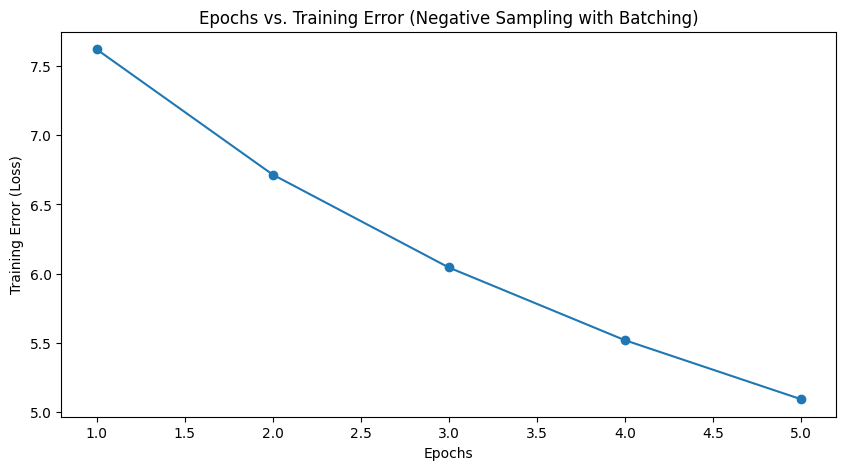

In [ ]:
# Plotting Epochs vs. Training Error
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), all_losses, marker='o')
plt.title('Epochs vs. Training Error (Negative Sampling with Batching)')
plt.xlabel('Epochs')
plt.ylabel('Training Error (Loss)')
plt.show()

* Saving the trained model and word embeddings for future use.

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'SkipGram_Neg_Samp_A4.pth')

In [ ]:
# Save word embeddings
word_embeddings = model.in_embedding.weight.data.cpu().numpy()  # Move to CPU before saving

# Create a DataFrame for word embeddings
embeddings_df = pd.DataFrame(word_embeddings, index=vocabulary)
embeddings_df.to_csv('word_embeddings.csv')

### **Task 7**: Test Analogies
Provide at least one example to test word analogies. The chosen words should not include the following
terms: ”man,” ”woman,” ”boy,” ”girl,” ”country,” ”city,” ”malware,” ”virus,” and their synonyms. Ensure
that two of the selected words used in the analogy are related to COVID-19.

In [ ]:
import pandas as pd

# Load word embeddings from CSV
embeddings_df = pd.read_csv('word_embeddings.csv', index_col=0)
embeddings = torch.tensor(embeddings_df.values).to(device)  # Convert to tensor and move to GPU if available

# Create a mapping from index to word
idx_to_word = embeddings_df.index.tolist()
word_to_idx = {word: idx for idx, word in enumerate(idx_to_word)}

In [ ]:
import random

# Forbidden words and their synonyms
forbidden_words = {"man", "woman", "boy", "girl", "country", "city", "malware", "virus"}

# This can be expanded with more synonyms as needed
forbidden_synonyms = {"male", "female", "child", "nation", "metropolis", "infection"}

# COVID-19 related words (you can expand this list as needed)
covid_related_words = {"pandemic", "sickness", "infection", "quarantine", "transmission", "symptom", "outbreak", "prevention", "isolation", "vaccination"}

# Load word embeddings from CSV
embeddings_df = pd.read_csv('word_embeddings.csv', index_col=0)

# Create a list of available words, excluding forbidden words and their synonyms
words_list = [word for word in embeddings_df.index if word not in forbidden_words and word not in forbidden_synonyms]

# Create a list of available COVID-19 related words
available_covid_words = [word for word in words_list if word in covid_related_words]

In [ ]:
def create_custom_examples(num_examples=5):
    """
    Create custom analogy examples.
    """
    examples = []
    for _ in range(num_examples):
        # Select two COVID-19 related words
        word_a, word_b = random.sample(available_covid_words, 2)

        # Select a third word from the general vocabulary (not restricted to COVID-19)
        remaining_words = [word for word in words_list if word not in available_covid_words]
        word_c = random.choice(remaining_words)

        examples.append((word_a, word_b, word_c))
    return examples

In [ ]:
# Create the custom examples list
examples = create_custom_examples(num_examples=5)
print(np.array(examples))

[['sickness' 'isolation' 'incidence']
 ['prevention' 'isolation' 'prototype']
 ['quarantine' 'pandemic' 'shocks']
 ['vaccination' 'quarantine' 'grains']
 ['pandemic' 'symptom' 'optimize']]


Given three words `word_a`, `word_b`, and `word_c`, we aim to find a fourth word `word_d` that completes the analogy:

`word_a` is to `word_b` as `word_c` is to `word_d`

$ \text{or, } e_a - e_b ≃ e_c - e_d$

To find `word_d`, we compute an analogy vector $v_{analogy}$ based on the embeddings $e_a$, $e_b$ and $e_c$

$$
\vec{v}_{\text{analogy}} = \vec{e}_b - \vec{e}_a + \vec{e}_c
$$

This vector is then compared to each word embedding $e_w$ in the vocabulary by calculating the similarity:

$$
\text{similarity} = \vec{v}_{\text{analogy}} \cdot \vec{e}_w
$$

The word with the highest similarity score is selected as the answer to the analogy.

In [ ]:
def test_analogy(word_a, word_b, word_c):
    """
    Test the analogy between word_a, word_b, and word_c.
    """
    # Get the indices of the words
    idx_a = word_to_idx[word_a]
    idx_b = word_to_idx[word_b]
    idx_c = word_to_idx[word_c]

    # Calculate the analogy vector
    analogy_vector = embeddings[idx_b] - embeddings[idx_a] + embeddings[idx_c]

    # Get the nearest word in the vocabulary
    similarities = torch.matmul(embeddings, analogy_vector)  # Similarity scores
    most_similar_word_idx = torch.argmax(similarities).item()

    # Return the most similar word
    return idx_to_word[most_similar_word_idx]

In [ ]:
# Testing each analogy example
for word_a, word_b, word_c in examples:
    result = test_analogy(word_a, word_b, word_c)
    BLUE = '\033[94m'
    RESET = '\033[0m'
    # Modified print statement
    print(f"Analogy result for '{word_a}' is to '{word_b}' as '{BLUE}{result}{RESET}' is to '{word_c}'")

Analogy result for 'sickness' is to 'isolation' as 'vertebrate' is to 'incidence'
Analogy result for 'prevention' is to 'isolation' as 'prototype' is to 'prototype'
Analogy result for 'quarantine' is to 'pandemic' as 'shocks' is to 'shocks'
Analogy result for 'vaccination' is to 'quarantine' as 'grains' is to 'grains'
Analogy result for 'pandemic' is to 'symptom' as 'optimize' is to 'optimize'


## Assignment 05

There are two matrices in this word2vec `SkipGramNegSamp` model
* $W_{in}$ - connecting the input and hidden layer
* $W_{out}$ - connecting the hidden and the output layer

Usually $W_{in}$ is used for word embedding and $W_{out}$ is ignored. In this assignment, you will execute the following:

### **Task 1**: Find similar words for a word of your choice using $W_{in}$

In [ ]:
# Create idx_to_word by reversing the word_to_idx dictionary
idx_to_word = {index: word for word, index in word_to_idx.items()}

In [ ]:
def get_word_embedding(word, embedding_matrix, word_to_idx):
    """
    Get the embedding vector for a given word.
    """
    word_idx = word_to_idx[word]
    return embedding_matrix[word_idx]

def find_similar_words(word, embedding_matrix, word_to_idx, idx_to_word, top_k=5):
    """
    Find similar words to a given word based on cosine similarity.
    """
    # Get the embedding for the given word
    word_embedding = get_word_embedding(word, embedding_matrix, word_to_idx)
    similarities = []

    # Compute cosine similarity with all other words
    for i, embedding in enumerate(embedding_matrix):
        sim = torch.cosine_similarity(torch.tensor(word_embedding), torch.tensor(embedding), dim=0)
        similarities.append((idx_to_word[i], sim.item()))

    # Sort by similarity and return the top-k most similar words
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    return similarities[:top_k]

In [ ]:
# Using Win matrix
similar_words_win = find_similar_words("patients", model.in_embedding.weight.detach().cpu().numpy(), word_to_idx, idx_to_word)

In [ ]:
similar_words_win

[('patients', 1.0),
 ('infection', 0.7654737234115601),
 ('disease', 0.7362645864486694),
 ('study', 0.7117049694061279),
 ('data', 0.6768487691879272)]

In [ ]:
print("Similar words for 'patients' (W_input):")
print()
for word, similarity in similar_words_win:
    print(f'{word}: {similarity:.4f}')

Similar words for 'patients' (W_input):

patients: 1.0000
infection: 0.7655
disease: 0.7363
study: 0.7117
data: 0.6768


### **Task 2**: Find the similar words for the same word chosen in (1) using $W_{out}$

In [ ]:
# Using Wout matrix
similar_words_wout = find_similar_words("patients", model.out_embedding.weight.detach().cpu().numpy(), word_to_idx, idx_to_word)

In [ ]:
similar_words_wout

[('patients', 1.0000001192092896),
 ('pandemic', 0.45847299695014954),
 ('infection', 0.42095503211021423),
 ('study', 0.39711931347846985),
 ('may', 0.3768135607242584)]

In [ ]:
print("Similar words for 'patients' (W_output):")
print()
for word, similarity in similar_words_wout:
    print(f'{word}: {similarity:.4f}')

Similar words for 'patients' (W_output):

patients: 1.0000
pandemic: 0.4585
infection: 0.4210
study: 0.3971
may: 0.3768


### **Task 3** : Find the similar words for the same word chosen in (1) after combining $W_{in}$ and $W_{out}$ - either concatenate them to have a longer vector or average them out

In [ ]:
def combine_embeddings(word, in_matrix, out_matrix, word_to_idx, method='concat'):
    """
    Combine embeddings from in_matrix and out_matrix based on the specified method.
    """
    # Assuming idx_to_word is a dictionary mapping index to word
    word = idx_to_word.get(word)  # If word is an index, get the actual word

    if word is not None and word in word_to_idx:
        in_embedding = get_word_embedding(word, in_matrix, word_to_idx)
        out_embedding = get_word_embedding(word, out_matrix, word_to_idx)

        if method == 'concat':
            combined_embedding = np.concatenate((in_embedding, out_embedding))
        elif method == 'average':
            combined_embedding = (in_embedding + out_embedding) / 2

        return combined_embedding
    else:
        return np.zeros(in_matrix.shape[1] + out_matrix.shape[1] if method == 'concat' else in_matrix.shape[1])

* Using `average` of $W_{in}$ and $W_{out}$ for `combined_embeddings`

In [ ]:
combined_embeddings = np.array([combine_embeddings(w, model.in_embedding.weight.detach().cpu().numpy(),
                                        model.out_embedding.weight.detach().cpu().numpy(),
                                        word_to_idx, method='average') for w in idx_to_word])

In [ ]:
similar_words_combined = find_similar_words("patients", combined_embeddings, word_to_idx, idx_to_word)

In [ ]:
similar_words_combined

[('patients', 0.9999998807907104),
 ('pandemic', 0.5272459387779236),
 ('infection', 0.52550208568573),
 ('study', 0.5064181685447693),
 ('may', 0.4640401303768158)]

In [ ]:
print("Similar words for 'patients' (W_combined):")
print()
for word, similarity in similar_words_combined:
    print(f'{word}: {similarity:.4f}')

Similar words for 'patients' (W_combined):

patients: 1.0000
pandemic: 0.5272
infection: 0.5255
study: 0.5064
may: 0.4640


### **Task 4**: Compare the results of (1), (2) and (3) and write a brief description of the outcome

#### Comparison of Results
1. Similar Words from Input Embeddings ($W_{in}$):

  * The top similar words for the query `patients` were `infection`, `disease`, `study`, and `data`, with a maximum similarity score of 1.0000 for the word itself.
  * This outcome indicates that $W_{in}$ effectively captures relationships related to medical terms and research, reflecting its focus on context within input sentences.

2. Similar Words from Output Embeddings ($W_{out}$):

  * For $W_{out}$, the similar words were `pandemic`,`infection`, `study`, and `may`, with a maximum similarity score of 1.0000 for the word itself.
  * The presence of `pandemic` highlights a broader contextual understanding, suggesting that the output embeddings capture not only the immediate context but also extend to related concepts, possibly influenced by the surrounding training data.

3. Similar Words from Combined Embeddings ($W_{comb}$):

  * The combined embeddings yielded similar words including `pandemic`, `infection`, `study`, and `may`, with the highest similarity score at 1.0000 for the word itself.
  * Although the top similar words are the same as those from
$W_{out}$, the similarity scores differ slightly, indicating that
$W_{comb}$, $W_{in}$ and $W_{out}$, albeit leaning more towards the characteristics of
$W_{out}$.

**Comments**:

* The results illustrate that while both $W_{out}$ and $W_{comb}$  provide $W_{in}$,  focuses more on specific medical contexts.
* This suggests that the input embeddings capture detailed semantic nuances, whereas the output embeddings, particularly in their combined form, tend to generalize concepts more broadly.
* The similarity scores highlight the unique contributions of each embedding type, emphasizing the importance of considering different embedding strategies in natural language processing tasks.
* Future training with additional epochs may further enhance the distinctiveness and effectiveness of these embeddings.

### **Task 5**: A slide related to the complexities of skipgram and CBOW model was shown in the class. Check if they are correct. If not, what are the correct entries?

**The Model: Skip-gram with Negative Sampling**  

**Skip-gram Model**:

* The **Skip-gram** model aims to predict context words given a target word.  
* For each target word, several context words (within a window) are used, and negative sampling is employed to predict unrelated words (negative samples).

**Negative Sampling**:

* The goal of **negative sampling** is to update only a few of the output weights rather than the entire output layer.
* Instead of updating the entire vocabulary, it updates a small subset of words.  

**Complexity of the Skip-gram Model with Negative Sampling**:

From the slide, the complexity is:
`O(T · N · C · k)`

Where:

- **T**: Total number of words in the corpus.  
- **N**: Embedding size (here, `embedding_dim = 128`).  
- **C**: Context window size (here, `window_size = 2`).  
- **k**: Number of negative samples (here, `num_negative_samples = 5`).  

The above model follows this complexity because:

- The forward pass involves dot products between the target word and context word embeddings (`target_embedding * context_embedding`) for positive pairs.  
- Similarly, for negative sampling, I have performed dot products between the target word embedding and negative word embeddings.  
- For each word, I am calculating both positive and negative losses, so the number of operations per word is proportional to **C** (number of context words) and **k** (negative samples).

Thus, **this model’s complexity is indeed `O(T · N · C · k)`**.